# Correcting Barium Records for Arctic rivers

* This notebook is a summary of what I did in finding the relationship between fluvial Ba records and river discharge in 6 largest Arctic rivers.
* Updated on 2015/05/08, No more discharge issues, just correcting Ba records to a seasonal cycle.
* Updated on 2015/07/13, Small rivers added
* Updated on 2016/01/18. Delete one of the "drop down" signal.

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**Define functions**](#Define-functions)
1. [**Barium records**](#Barium-records)
  2. [Read datasets](#Read-datasets)
  2. [Combine datasets to series](#Combine-datasets-to-series)
  2. [Reconstruct to monthly mean values](#Reconstruct-to-monthly-mean-values)
1. [**Create Ba forcing**](#Create-Ba-forcing)
  2. [Scaled ensemble result](#Scaled-ensemble-result)
  2. [Fill missing values](#Fill-missing-values)
  2. [Plot the forcing Ba](#Plot-the-forcing-Ba)
1. [**Save-results**](#Save-results)

# Import modules and tools

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime, datetime2datenum_single 

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
import matplotlib.pyplot as plt
#from seaborn import xkcd_rgb as xcolor
% matplotlib inline

In [3]:
reload(Nts)

<module 'NEMO_tools' from '_libs/NEMO_tools.pyc'>

# Define functions

In [4]:
def find_same_month(dt, data, month):
    '''
    =======================================================================
    Selecting data points in a certain month (but different years)
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
    selected_data = seasonal_character(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
            month: the month you want to select
    Output:
            selected_data: selected data
    ======================================================================= 
    '''
    out=[]
    for i in range(len(dt)):
        if dt[i].month==month:
            out=out+[data[i].tolist()]
    return np.array(out)
# plot mon bin
def plot_mon_bin(dt, data, ax):
    for i in range(1, 13):
        out=find_same_month(dt, data, i)
        ax.plot((i+0.35)*np.ones(np.size(out)), out, 'o', mfc=[0.94, 0.92, 0.84], mec='k', ms=10, mew=1.5)
        if i==6:
            ax.plot((i+0.35), out[0], 'o', mfc=[0.94, 0.92, 0.84], mec='k', ms=10, mew=1.5, label='Daily obs. in that month')

In [5]:
def smallr(monmean, ratio):
    return np.nanmean(monmean)/np.mean(ratio[~np.isnan(monmean)])*ratio

In [6]:
def mutifig6(SIZE=(16, 12)):
    fig=plt.figure(figsize=SIZE)
    plt.subplots_adjust(hspace = 0.25)
    ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
    ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
    ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
    ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
    ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
    ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)
    #ax = fig.add_subplot(111)  
    #ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.spines['right'].set_color('none')
    #ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    AX = [ax1, ax2, ax3, ax4, ax5, ax6]
    return fig, AX

In [7]:
Mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
SB=[0.06, 0.05, 0.03]    # Smokey Black
AFB = [0.36, 0.54, 0.66] # Air Force Blue
AG = [0.55, 0.71, 0.0]   # Apple Green
AZ = [0.0, 0.5, 1.0]     # Azure
CB = [0.37, 0.62, 0.63]  # Cadet blue
SP = [1.0, 0.72, 0.77]   # Sakura
CamB = [0.64, 0.76, 0.68]# Cambridge blue
DC = [0.0, 0.55, 0.55]   # Dark cyan
DE = [0.08, 0.38, 0.74]  # Denim
BB = [0.54, 0.81, 0.94]  # Baby blue

# Barium records

Datasets are downloaded from <a href='http://www.arcticgreatrivers.org/data'>**Arctic Great River Observatory**</a>. All datasets have been preprocessed in MATLAB.

The unit is nM (1E-6 mol/L).

**Locations of Observatories**

<table align="left">
<tr>
<th>River</th>
<th>Station</th>
<th>Longitude</th>
<th>Latitude</th>
</tr>
<tr>
<td>Lena</td>
<td>Zhigansk</td>
<td>123°22' E</td>
<td>66°46' N</td>
</tr>
<tr>
<td>Kolyma</td>
<td>Cherskiy</td>
<td>161°18' E</td>
<td>68°45' N</td>
</tr>
<tr>
<td>Yenisey</td>
<td>Dudinka</td>
<td>86°09' E</td>
<td>69°23' N</td>
</tr>
<tr>
<td>Mackenzie</td>
<td>Tsiigehtchic / Inuvik</td>
<td>133°45' W / 133°42' W</td>
<td>67°26' N / 68°20' N</td>
</tr>
<tr>
<td>Ob'</td>
<td>Salekhard</td>
<td>66°36' E</td>
<td>66°31' N</td>
</tr>
<tr>
<td>Yukon</td>
<td>Pilot Station</td>
<td>162°52' W</td>
<td>61°56' N</td>
</tr>
</table>

## Read datasets

** PARTNERS [L. W. Cooper et al., Geophys. Res. Lett., 2008] **

In [9]:
PARTNERS_name=glob.glob('../../Arctic-obs/MATLAB files/*PATRNERS*.mat')
print("found file: \n{}".format(PARTNERS_name))
PARTNERS_obj=scipy.io.loadmat(PARTNERS_name[0])

found file: 
['../../Arctic-obs/MATLAB files/River_PATRNERS_Ba.mat']


In [10]:
PARTNERS_Lena      = PARTNERS_obj['Lena']
PARTNERS_Kolyma    = PARTNERS_obj['Kolyma']
PARTNERS_Yenisey   = PARTNERS_obj['Yenisey']
PARTNERS_Mackenzie = PARTNERS_obj['Mackenzie']
PARTNERS_Ob        = PARTNERS_obj['Ob']
PARTNERS_Yukon     = PARTNERS_obj['Yukon']

** Arctic-GRO **

In [11]:
AGRO_name=glob.glob('../../Arctic-obs/MATLAB files/*AGRO*.mat')
print("found file: \n{}".format(AGRO_name))
AGRO_obj=scipy.io.loadmat(AGRO_name[0])

found file: 
['../../Arctic-obs/MATLAB files/River_AGRO_Ba.mat']


In [12]:
AGRO_Lena      = AGRO_obj['Lena']
AGRO_Kolyma    = AGRO_obj['Kolyma']
AGRO_Yenisey   = AGRO_obj['Yenisey']
AGRO_Mackenzie = AGRO_obj['Mackenzie']
AGRO_Ob        = AGRO_obj['Ob']
AGRO_Yukon     = AGRO_obj['Yukon']

** ARCSS 1993-1996 **

In [13]:
ARC_name=glob.glob('../../Arctic-obs/MATLAB files/*ARCSS*.mat')
print("found file: \n{}".format(ARC_name))
ARC_obj=scipy.io.loadmat(ARC_name[0])

found file: 
['../../Arctic-obs/MATLAB files/River_ARCSS_Ba.mat']


In [14]:
ARC_Mackenzie = ARC_obj['Mackenzie']
ARC_Indigirka = ARC_obj['Indigirka']
ARC_Kolyma    = ARC_obj['Kolyma']
ARC_Pechora   = ARC_obj['Pechora']
ARC_Pyasina   = ARC_obj['Pyasina']
ARC_Taimyra   = ARC_obj['Taimyra']
ARC_Yana      = ARC_obj['Yana']
ARC_Yenisey   = ARC_obj['Yenisey']
ARC_Olenek    = ARC_obj['Olenek']
ARC_Khatanga  = ARC_obj['Khatanga'] 

** SCARFS ** (Small Canadian rivers)

In [15]:
SCARFS_name=glob.glob('../../Arctic-obs/MATLAB files/*SCARFS*.mat')
print("found file: \n{}".format(SCARFS_name))
SCARFS_obj=scipy.io.loadmat(SCARFS_name[0])

found file: 
['../../Arctic-obs/MATLAB files/River_SCARFS_Ba.mat']


In [16]:
SCARFS_CPM     = SCARFS_obj['CPM']
SCARFS_Back    = SCARFS_obj['Back']
SCARFS_Hayes   = SCARFS_obj['Hayes']
SCARFS_CH      = SCARFS_obj['CH']
SCARFS_Clyde   = SCARFS_obj['Clyde']
SCARFS_Thomsen = SCARFS_obj['Thomsen']

** NCAR/EOL **

* [M. Alkire] Small Canadian Arctic River Flows https://www.aoncadis.org/dataset/SCARFs.html
* [K. Falkner] Arctic River Ba Con., 1993-1996 https://www.aoncadis.org/dataset/ucar.ncar.eol.dataset.106_ARCSS107.html

## Combine datasets to series

Combine datetime.datetime objects

In [17]:
Lena_time      = datenum2datetime(PARTNERS_Lena[:, 0])  + datenum2datetime(AGRO_Lena[:, 0])
Kolyma_time    = datenum2datetime(ARC_Kolyma[:, 0])     + datenum2datetime(PARTNERS_Kolyma[:, 0])    + datenum2datetime(AGRO_Kolyma[:, 0]) 
Yenisey_time   = datenum2datetime(ARC_Yenisey[:, 0])    + datenum2datetime(PARTNERS_Yenisey[:, 0])   + datenum2datetime(AGRO_Yenisey[:, 0])  
Mackenzie_time = datenum2datetime(ARC_Mackenzie[:, 0])  + datenum2datetime(PARTNERS_Mackenzie[:, 0]) + datenum2datetime(AGRO_Mackenzie[:, 0])
Ob_time        = datenum2datetime(PARTNERS_Ob[:, 0])    + datenum2datetime(AGRO_Ob[:, 0])
Yukon_time     = datenum2datetime(PARTNERS_Yukon[:, 0]) + datenum2datetime(AGRO_Yukon[:, 0])
# Small Russia rivers
Indigirka_time = datenum2datetime(ARC_Indigirka[:, 0])
Khatanga_time  = datenum2datetime(ARC_Khatanga[:, 0])
Pechora_time   = datenum2datetime(ARC_Pechora[:, 0])
Pyasina_time   = datenum2datetime(ARC_Pyasina[:, 0])
Taimyra_time   = datenum2datetime(ARC_Taimyra[:, 0])
Yana_time      = datenum2datetime(ARC_Yana[:, 0])
Olenek_time    = datenum2datetime(ARC_Olenek[:, 0])
# Small Canadian rivers
CPM_time       = datenum2datetime(SCARFS_CPM[:, 0])
Back_time      = datenum2datetime(SCARFS_Back[:, 0])
Hayes_time     = datenum2datetime(SCARFS_Hayes[:, 0])
CH_time        = datenum2datetime(SCARFS_CH[:, 0])
Clyde_time     = datenum2datetime(SCARFS_Clyde[:, 0])
Thomsen_time   = datenum2datetime(SCARFS_Thomsen[:, 0])

Combine Ba records

In [18]:
Lena_Ba      = np.hstack((PARTNERS_Lena[:, 1] , AGRO_Lena[:, 1]))
Kolyma_Ba    = np.hstack((ARC_Kolyma[:, 1]    , PARTNERS_Kolyma[:, 1]   , AGRO_Kolyma[:, 1]))
Yenisey_Ba   = np.hstack((ARC_Yenisey[:, 1]   , PARTNERS_Yenisey[:, 1]  , AGRO_Yenisey[:, 1]))
Mackenzie_Ba = np.hstack((ARC_Mackenzie[:, 1] , PARTNERS_Mackenzie[:, 1], AGRO_Mackenzie[:, 1]))
Ob_Ba        = np.hstack((PARTNERS_Ob[:, 1]   , AGRO_Ob[:, 1]))
Yukon_Ba     = np.hstack((PARTNERS_Yukon[:, 1], AGRO_Yukon[:, 1]))
# Small Russia rivers
Indigirka_Ba = ARC_Indigirka[:, 1]
Khatanga_Ba  = ARC_Khatanga[:, 1]
Pechora_Ba   = ARC_Pechora[:, 1]
Pyasina_Ba   = ARC_Pyasina[:, 1]
Taimyra_Ba   = ARC_Taimyra[:, 1]
Yana_Ba      = ARC_Yana[:, 1]
Olenek_Ba    = ARC_Olenek[:, 1]
# Small Canadian rivers
CPM_Ba       = SCARFS_CPM[:, 1]
Back_Ba      = SCARFS_Back[:, 1]
Hayes_Ba     = SCARFS_Hayes[:, 1]
CH_Ba        = SCARFS_CH[:, 1]
Clyde_Ba     = SCARFS_Clyde[:, 1]
Thomsen_Ba   = SCARFS_Thomsen[:, 1]

## Reconstruct to monthly mean values

Bin raw data to monthly mean values

In [19]:
Lena_monmean     , Lena_Ba_monmean     , Lena_bin      = Nts.bin_monmean(Lena_time, Lena_Ba)
Kolyma_monmean   , Kolyma_Ba_monmean   , Kolyma_bin    = Nts.bin_monmean(Kolyma_time, Kolyma_Ba)
Yenisey_monmean  , Yenisey_Ba_monmean  , Yenisey_bin   = Nts.bin_monmean(Yenisey_time, Yenisey_Ba)
Mackenzie_monmean, Mackenzie_Ba_monmean, Mackenzie_bin = Nts.bin_monmean(Mackenzie_time, Mackenzie_Ba)
Ob_monmean       , Ob_Ba_monmean       , Ob_bin        = Nts.bin_monmean(Ob_time, Ob_Ba)
Yukon_monmean    , Yukon_Ba_monmean    , Yukon_bin     = Nts.bin_monmean(Yukon_time, Yukon_Ba)

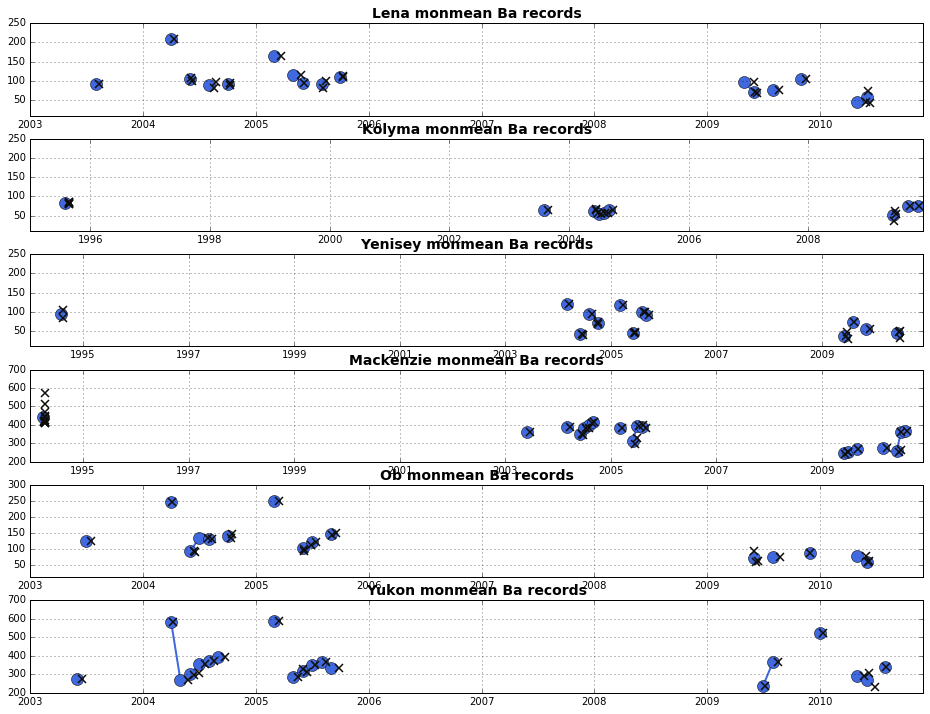

In [20]:
fig, AX = mutifig6()
for i in range(6):
    AX[i].grid()
#
AX[0].plot(Lena_monmean, Lena_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[0].plot(Lena_time, Lena_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[0].set_xlim(Lena_monmean[0], Lena_monmean[-1]); AX[0].set_ylim(10, 250)
AX[0].set_title('Lena monmean Ba records', fontsize=14, fontweight='bold')
#
AX[1].plot(Kolyma_monmean, Kolyma_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[1].plot(Kolyma_time, Kolyma_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[1].set_xlim(Kolyma_monmean[0], Kolyma_monmean[-1]); AX[1].set_ylim(10, 250)
AX[1].set_title('Kolyma monmean Ba records', fontsize=14, fontweight='bold')
#
AX[2].plot(Yenisey_monmean, Yenisey_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[2].plot(Yenisey_time, Yenisey_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[2].set_xlim(Yenisey_monmean[0], Yenisey_monmean[-1]); AX[2].set_ylim(10, 250)
AX[2].set_title('Yenisey monmean Ba records', fontsize=14, fontweight='bold') 
#
AX[3].plot(Mackenzie_monmean, Mackenzie_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[3].plot(Mackenzie_time, Mackenzie_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[3].set_xlim(Mackenzie_monmean[0], Mackenzie_monmean[-1]); AX[3].set_ylim(200, 700)
AX[3].set_title('Mackenzie monmean Ba records', fontsize=14, fontweight='bold')
#
AX[4].plot(Ob_monmean, Ob_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[4].plot(Ob_time, Ob_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[4].set_xlim(Ob_monmean[0], Ob_monmean[-1]); AX[4].set_ylim(10, 300)
AX[4].set_title('Ob monmean Ba records', fontsize=14, fontweight='bold')
#
AX[5].plot(Yukon_monmean, Yukon_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[5].plot(Yukon_time, Yukon_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[5].set_xlim(Yukon_monmean[0], Yukon_monmean[-1]); AX[5].set_ylim(200, 700)
AX[5].set_title('Yukon monmean Ba records', fontsize=14, fontweight='bold')

# Create Ba forcing

In [21]:
Lena_Ba_seasonal     , _ = Nts.bin_season_cycle(Lena_time, Lena_Ba)
Kolyma_Ba_seasonal   , _ = Nts.bin_season_cycle(Kolyma_time, Kolyma_Ba)
Yenisey_Ba_seasonal  , _ = Nts.bin_season_cycle(Yenisey_time, Yenisey_Ba)
Mackenzie_Ba_seasonal, _ = Nts.bin_season_cycle(Mackenzie_time, Mackenzie_Ba)
Ob_Ba_seasonal       , _ = Nts.bin_season_cycle(Ob_time, Ob_Ba)
Yukon_Ba_seasonal    , _ = Nts.bin_season_cycle(Yukon_time, Yukon_Ba)
# Small Russia River 
Indigirka_Ba_seasonal, _ = Nts.bin_season_cycle(Indigirka_time, Indigirka_Ba)
Khatanga_Ba_seasonal, _  = Nts.bin_season_cycle(Khatanga_time, Khatanga_Ba)
Pechora_Ba_seasonal  , _ = Nts.bin_season_cycle(Pechora_time, Pechora_Ba)
Pyasina_Ba_seasonal  , _ = Nts.bin_season_cycle(Pyasina_time, Pyasina_Ba)
Taimyra_Ba_seasonal  , _ = Nts.bin_season_cycle(Taimyra_time, Taimyra_Ba)
Yana_Ba_seasonal     , _ = Nts.bin_season_cycle(Yana_time, Yana_Ba)
Olenek_Ba_seasonal   , _ = Nts.bin_season_cycle(Olenek_time, Olenek_Ba)
# Suall Canada River
CPM_Ba_seasonal      , _ = Nts.bin_season_cycle(CPM_time, CPM_Ba)
Back_Ba_seasonal     , _ = Nts.bin_season_cycle(Back_time, Back_Ba)
Hayes_Ba_seasonal    , _ = Nts.bin_season_cycle(Hayes_time, Hayes_Ba)
CH_Ba_seasonal       , _ = Nts.bin_season_cycle(CH_time, CH_Ba)
Clyde_Ba_seasonal    , _ = Nts.bin_season_cycle(Clyde_time, Clyde_Ba)
Thomsen_Ba_seasonal  , _ = Nts.bin_season_cycle(Thomsen_time, Thomsen_Ba)

In [22]:
t = np.arange(1, 13)

## Scaled ensemble result

In [23]:
allBa = np.empty([6, 12])
allBa[0, :] = Lena_Ba_seasonal/np.nanmean(Lena_Ba_seasonal)
allBa[1, :] = Kolyma_Ba_seasonal/np.nanmean(Kolyma_Ba_seasonal)
allBa[2, :] = Yenisey_Ba_seasonal/np.nanmean(Yenisey_Ba_seasonal)
allBa[3, :] = Mackenzie_Ba_seasonal/np.nanmean(Mackenzie_Ba_seasonal)
allBa[4, :] = Ob_Ba_seasonal/np.nanmean(Ob_Ba_seasonal)
allBa[5, :] = Yukon_Ba_seasonal/np.nanmean(Yukon_Ba_seasonal)

In [24]:
meanBa = np.nanmean(allBa, 0)
maxBa  = np.nanmax(allBa, 0)
minBa  = np.nanmin(allBa, 0)
#
errbar = np.nanstd(allBa, 0)
errbar[errbar==0]=np.nan

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [26]:
from matplotlib.patches import Rectangle

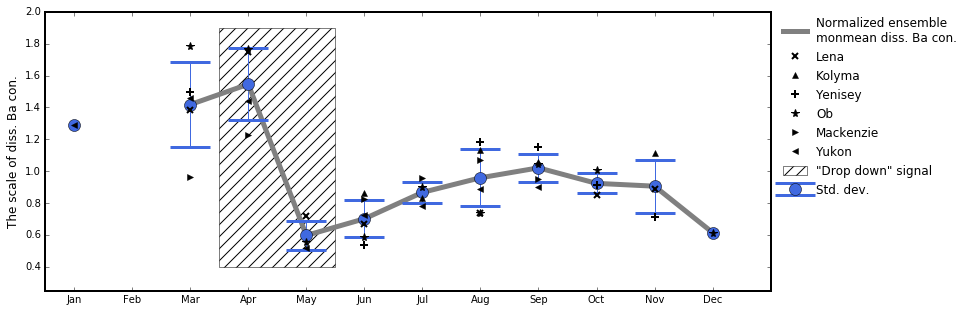

In [28]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
# line
ax.plot(t, meanBa, '-', color='gray', linewidth=5, label='Normalized ensemble\nmonmean diss. Ba con.')
# hatch boxes
ax.add_patch(Rectangle((3.5, 0.4), 2, 1.5, facecolor='None', hatch='//', linewidth=0.5, label='"Drop down" signal'))
#ax.add_patch(Rectangle((10.5, 0.5), 2, 0.8, facecolor='None', hatch='//', linewidth=0.5))
# errorbar, circles
ax.errorbar(t, meanBa, yerr=errbar, fmt='o', ms=12, mfc=RB, ecolor=RB, capthick=3, capsize=20, label='Std. dev.')
# markers for rivers
ax.plot(t, allBa[0, :].T, 'x', ms=6, mew=2, color='k', label = 'Lena')
ax.plot(t, allBa[1, :].T, '^', ms=6, mew=0.5, color='k', label = 'Kolyma')
ax.plot(t, allBa[2, :].T, '+', ms=8, mew=2, color='k', label = 'Yenisey')
ax.plot(t, allBa[4, :].T, '*', ms=8, mew=1, color='k', label = "Ob")
ax.plot(t, allBa[3, :].T, '>', ms=6, mew=0.5, color='k', label = 'Mackenzie')
ax.plot(t, allBa[5, :].T, '<', ms=6, mew=0.5, color='k', label = 'Yukon')
# legend
LG = ax.legend(numpoints=1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
# bold frame
[i.set_linewidth(2) for i in ax.spines.itervalues()]
# axis
ax.set_ylabel('The scale of diss. Ba con.', fontsize=12)
ax.set_xlim(0.5, 13); ax.set_ylim(0.25, 2)
ax.set_xticks(range(1, 13)); ax.set_xticklabels(Mon)
#fig.savefig('scaled_ensemble_Ba.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0.01)
fig.savefig('_publish/FIG1.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
                bbox_inches='tight', pad_inches=0.1)

## Fill missing values

In [29]:
# Lena
# - Drop down
Lena_Ba_re = np.copy(Lena_Ba_seasonal)
# -- Dec
#Lena_Ba_re[-1] = meanBa[-1]*np.nanmean(Lena_Ba_seasonal)
Lena_Ba_re[~np.isnan(Lena_Ba_seasonal)]=np.nan
# - interpolation
Lena_Ba_int = np.copy(Lena_Ba_seasonal)
# -- Jan, Feb
temp = Nts.int_between(Lena_Ba_seasonal[-2], Lena_Ba_seasonal[2], 3)
Lena_Ba_int[0:2] = temp[1:]
Lena_Ba_int[-1] = temp[0]
# -- Jul, Sep
Lena_Ba_int[6] = Nts.int_between(Lena_Ba_seasonal[5], Lena_Ba_seasonal[7], 1)
Lena_Ba_int[8] = Nts.int_between(Lena_Ba_seasonal[7], Lena_Ba_seasonal[9], 1)
# - Save results
Lena_Ba_nemo = np.copy(Lena_Ba_int); #Lena_Ba_nemo[-1] = Lena_Ba_re[-1]
Lena_Ba_int[~np.isnan(Lena_Ba_seasonal)]=np.nan

In [30]:
temp[1:]

array([ 135.4339408 ,  150.15452409])

In [31]:
# Kolyma
# - Drop down
Kolyma_Ba_re = np.copy(Kolyma_Ba_seasonal)
# -- Apr, May
Kolyma_Ba_re[3:5] = meanBa[3:5]*np.nanmean(Kolyma_Ba_seasonal)
# -- Dec
#Kolyma_Ba_re[-1] = meanBa[-1]*np.nanmean(Kolyma_Ba_seasonal)
Kolyma_Ba_re[~np.isnan(Kolyma_Ba_seasonal)]=np.nan
# - Interpolation
Kolyma_Ba_int = np.copy(Kolyma_Ba_seasonal)
# -- Jan, Feb, Mar
temp = Nts.int_between(Kolyma_Ba_seasonal[-2], Kolyma_Ba_re[3], 4)
Kolyma_Ba_int[0:3] = temp[1:]
Kolyma_Ba_int[-1] = temp[0]
# -- Oct
Kolyma_Ba_int[9] = Nts.int_between(Kolyma_Ba_seasonal[8], Kolyma_Ba_seasonal[10], 1)
Kolyma_Ba_nemo = np.copy(Kolyma_Ba_int)
# - Save results
Kolyma_Ba_nemo[3:5] = Kolyma_Ba_re[3:5]
#Kolyma_Ba_nemo[-1] = Kolyma_Ba_re[-1]
Kolyma_Ba_int[~np.isnan(Kolyma_Ba_seasonal)]=np.nan

In [32]:
# Yenisey
# - Drop down
Yenisey_Ba_re = np.copy(Yenisey_Ba_seasonal)
# -- Apr, May
Yenisey_Ba_re[3:5] = meanBa[3:5]*np.nanmean(Yenisey_Ba_seasonal)
# - Dec
#Yenisey_Ba_re[-1] = meanBa[-1]*np.nanmean(Yenisey_Ba_seasonal)
Yenisey_Ba_re[~np.isnan(Yenisey_Ba_seasonal)]=np.nan
# - Interpolation
Yenisey_Ba_int = np.copy(Yenisey_Ba_seasonal)
# -- Jan, Feb
temp = Nts.int_between(Yenisey_Ba_seasonal[-2], Yenisey_Ba_seasonal[2], 3)
Yenisey_Ba_int[0:2] = temp[1:]
Yenisey_Ba_int[-1] = temp[0]
# -- Jul
Yenisey_Ba_int[6] = Nts.int_between(Yenisey_Ba_seasonal[5], Yenisey_Ba_seasonal[7], 1)
# - Save result
Yenisey_Ba_nemo = np.copy(Yenisey_Ba_int); 
Yenisey_Ba_nemo[3:5] = Yenisey_Ba_re[3:5]; 
#Yenisey_Ba_nemo[-1] = Yenisey_Ba_re[-1]
Yenisey_Ba_int[~np.isnan(Yenisey_Ba_seasonal)]=np.nan

In [33]:
# Mackenzie
# - Drop down
Mackenzie_Ba_re = np.copy(Mackenzie_Ba_seasonal)
# -- May
Mackenzie_Ba_re[4:5] = meanBa[4:5]*np.nanmean(Mackenzie_Ba_seasonal)
# - Dec
#Mackenzie_Ba_re[-1] = meanBa[-1]*np.nanmean(Mackenzie_Ba_seasonal)
Mackenzie_Ba_re[~np.isnan(Mackenzie_Ba_seasonal)]=np.nan
# - Interpolation
Mackenzie_Ba_int = np.copy(Mackenzie_Ba_seasonal)
# -- Jan, Feb
temp = Nts.int_between(Mackenzie_Ba_seasonal[8], Mackenzie_Ba_seasonal[2], 5)
Mackenzie_Ba_int[9:12] = temp[0:3]
Mackenzie_Ba_int[0:2] = temp[3:]
# -- Oct, Nov
#Mackenzie_Ba_int[9:11] = Nts.int_between(Mackenzie_Ba_seasonal[8], Mackenzie_Ba_re[-1], 2)
# - Save result
Mackenzie_Ba_nemo = np.copy(Mackenzie_Ba_int); 
Mackenzie_Ba_nemo[4:5] = Mackenzie_Ba_re[4:5]; 
#Mackenzie_Ba_nemo[-1] = Mackenzie_Ba_re[-1]
Mackenzie_Ba_int[~np.isnan(Mackenzie_Ba_seasonal)]=np.nan

In [34]:
# Ob
# - Interpolation
Ob_Ba_int = np.copy(Ob_Ba_seasonal)
# -- Jan, Feb
Ob_Ba_int[0:2] = Nts.int_between(Ob_Ba_seasonal[-1], Ob_Ba_seasonal[2], 2)
# -- Nov
Ob_Ba_int[10] = Nts.int_between(Ob_Ba_seasonal[9], Ob_Ba_seasonal[11], 1)
# - Save result
Ob_Ba_nemo = np.copy(Ob_Ba_int)
Ob_Ba_int[~np.isnan(Ob_Ba_seasonal)]=np.nan

In [35]:
# Yukon
# - Drop down
Yukon_Ba_re = np.copy(Yukon_Ba_seasonal)
# -- Dec
#Yukon_Ba_re[-1] = meanBa[-1]*np.nanmean(Yukon_Ba_seasonal)
Yukon_Ba_re[~np.isnan(Yukon_Ba_seasonal)]=np.nan
# - Interpolation
Yukon_Ba_int = np.copy(Yukon_Ba_seasonal)
# -- Feb
Yukon_Ba_int[1] = Nts.int_between(Yukon_Ba_seasonal[0], Yukon_Ba_seasonal[2], 1)
# -- Oct, Nov
Yukon_Ba_int[9:12] = Nts.int_between(Yukon_Ba_seasonal[8], Yukon_Ba_seasonal[0], 3)
# - Save result
Yukon_Ba_nemo = np.copy(Yukon_Ba_int); #Yukon_Ba_nemo[-1] = Yukon_Ba_re[-1]
Yukon_Ba_int[~np.isnan(Yukon_Ba_seasonal)]=np.nan

## Plot the forcing Ba

In [36]:
Colors = plt.cm.RdBu_r(np.linspace(0, 1, 7))
RB = Colors[1]
AM = Colors[5]
Y = [1, 1, 0.5]

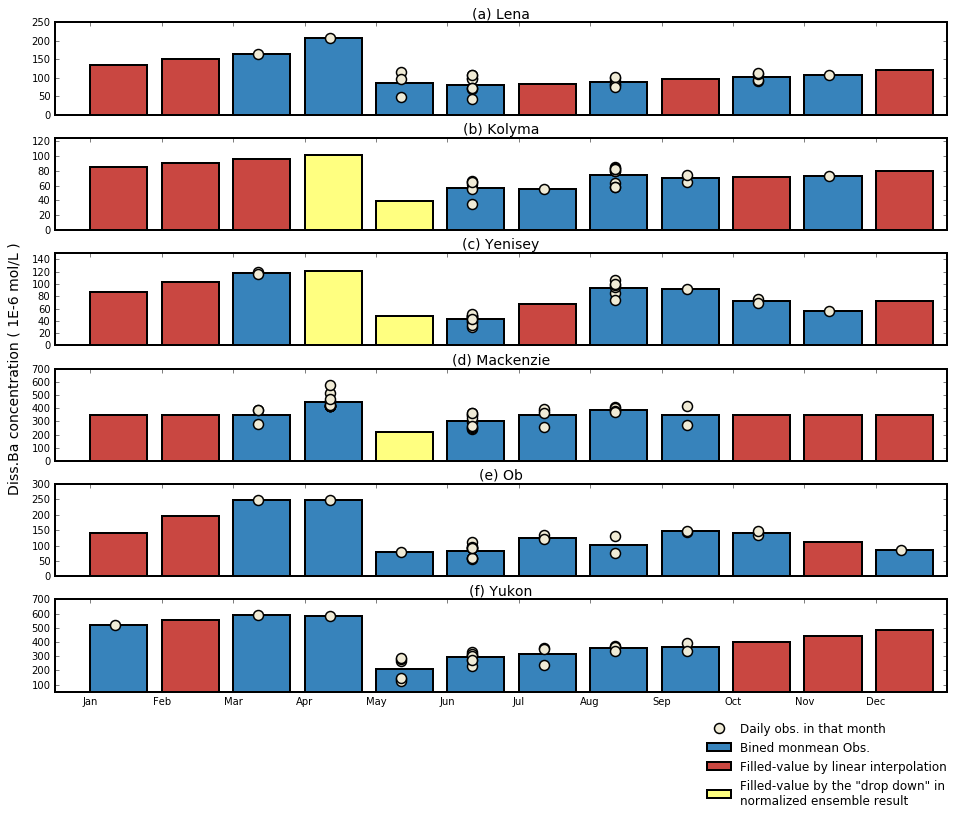

In [37]:
fig, AX = mutifig6()
for i in range(6):
    AX[i].set_xticks(t); AX[i].set_xlim(0.5, 13)
    [i.set_linewidth(2) for i in AX[i].spines.itervalues()]
# Lena
plot_mon_bin(Lena_time, Lena_Ba, AX[0]);
AX[0].bar(t, Lena_Ba_seasonal, color=RB, linewidth=2, label='Binned monmean Obs.'); 
AX[0].bar(t, Lena_Ba_int, color=AM, linewidth=2, label='Filled-value by linear interpolation')
AX[0].bar(t, Lena_Ba_re, color=Y, linewidth=2, label='Filled-value by the "drop down" in\nscaled ensemble result')
AX[0].set_ylim(0, 250); AX[0].set_title('(a) Lena', fontsize=14)#, fontweight='bold')
AX[0].tick_params(labelbottom='off') 
# Kolyma
plot_mon_bin(Kolyma_time, Kolyma_Ba, AX[1])
AX[1].bar(t, Kolyma_Ba_seasonal, color=RB, linewidth=2)
AX[1].bar(t, Kolyma_Ba_int, color=AM, linewidth=2); 
AX[1].bar(t, Kolyma_Ba_re, color=Y, linewidth=2); 
AX[1].set_ylim(0, 125); AX[1].set_title('(b) Kolyma', fontsize=14)#, fontweight='bold')
AX[1].tick_params(labelbottom='off') 
# Yenisey
plot_mon_bin(Yenisey_time, Yenisey_Ba, AX[2])
AX[2].bar(t, Yenisey_Ba_seasonal, color=RB, linewidth=2)
AX[2].bar(t, Yenisey_Ba_int, color=AM, linewidth=2); 
AX[2].bar(t, Yenisey_Ba_re, color=Y, linewidth=2); 
AX[2].set_ylim(0, 150); AX[2].set_title('(c) Yenisey', fontsize=14)#, fontweight='bold')
AX[2].tick_params(labelbottom='off') 
# Mackenzie
plot_mon_bin(Mackenzie_time, Mackenzie_Ba, AX[3])
AX[3].bar(t, Mackenzie_Ba_seasonal, color=RB, linewidth=2)
AX[3].bar(t, Mackenzie_Ba_int, color=AM, linewidth=2);
AX[3].bar(t, Mackenzie_Ba_re, color=Y, linewidth=2);
AX[3].set_ylim(0, 700); AX[3].set_title('(d) Mackenzie', fontsize=14)#, fontweight='bold')
AX[3].tick_params(labelbottom='off') 
# Ob
plot_mon_bin(Ob_time, Ob_Ba, AX[4])
AX[4].bar(t, Ob_Ba_seasonal, color=RB, linewidth=2); 
AX[4].bar(t, Ob_Ba_int, color=AM, linewidth=2);
AX[4].set_ylim(0, 300); AX[4].set_title("(e) Ob", fontsize=14)#, fontweight='bold')
AX[4].tick_params(labelbottom='off') 
# Yukon
plot_mon_bin(Yukon_time, Yukon_Ba, AX[5])
AX[5].bar(t, Yukon_Ba_seasonal, color=RB, linewidth=2, label='Bined monmean Obs.')
AX[5].bar(t, Yukon_Ba_int, color=AM, linewidth=2, label='Filled-value by linear interpolation');
AX[5].bar(t, Yukon_Ba_re, color=Y, linewidth=2, label='Filled-value by the "drop down" in\nnormalized ensemble result');
AX[5].set_ylim(50, 700); AX[5].set_title('(f) Yukon', fontsize=14)#, fontweight='bold')
AX[5].set_xticks(range(1, 13)); AX[5].set_xticklabels(Mon);
LG = AX[5].legend(numpoints=1, bbox_to_anchor=(0.725, -0.275), loc=2, borderaxespad=0.); LG.draw_frame(False) 

fig.text(0.09, 0.5, 'Diss.Ba concentration ( 1E-6 mol/L )', ha='center', va='center', rotation='vertical', fontsize=14)
fig.savefig('_publish/FIG2.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
            transparent=False, bbox_inches='tight', pad_inches=0)

## For small river

In [38]:
meanBa[0:2] = Nts.int_between(meanBa[11], meanBa[2], 2)

In [39]:
# Small Russia river 
Indigirka_Ba_nemo = smallr(Indigirka_Ba_seasonal, meanBa)
Khatanga_Ba_nemo  = smallr(Khatanga_Ba_seasonal, meanBa)
Pechora_Ba_nemo   = smallr(Pechora_Ba_seasonal, meanBa)
Pyasina_Ba_nemo   = smallr(Pyasina_Ba_seasonal, meanBa)
Taimyra_Ba_nemo   = smallr(Taimyra_Ba_seasonal, meanBa)
Yana_Ba_nemo      = smallr(Yana_Ba_seasonal, meanBa)
Olenek_Ba_nemo    = smallr(Olenek_Ba_seasonal, meanBa)
# Small Canadian river
CPM_Ba_nemo     = smallr(CPM_Ba_seasonal, meanBa)
Back_Ba_nemo    = smallr(Back_Ba_seasonal, meanBa)
Hayes_Ba_nemo   = smallr(Hayes_Ba_seasonal, meanBa)
CH_Ba_nemo      = smallr(CH_Ba_seasonal, meanBa)
Clyde_Ba_nemo   = smallr(Clyde_Ba_seasonal, meanBa)
Thomsen_Ba_nemo = smallr(Thomsen_Ba_seasonal, meanBa)

# Summary

In [40]:
major_Ba = [np.mean(Lena_Ba_nemo), np.mean(Kolyma_Ba_nemo), np.mean(Yenisey_Ba_nemo), \
                   np.mean(Mackenzie_Ba_nemo), np.mean(Ob_Ba_nemo), np.mean(Yukon_Ba_nemo)]
major_name = ['Lena', 'Kolyma', 'Yenisey', 'Mackenzie', 'Ob', 'Yukon']
Russia_small_Ba = [np.mean(Indigirka_Ba_nemo), np.mean(Pechora_Ba_nemo), np.mean(Pyasina_Ba_nemo), \
                   np.mean(Taimyra_Ba_nemo), np.mean(Khatanga_Ba_nemo), np.mean(Yana_Ba_nemo), np.mean(Olenek_Ba_nemo)]
Russia_name = ['Indigirka', 'Pechora', 'Pyasina', 'Taimyra', 'Khatanga', 'Yana', 'Olenek']
Canadian_small_Ba = [np.mean(CPM_Ba_nemo), np.mean(Back_Ba_nemo), np.mean(Hayes_Ba_nemo), np.mean(CH_Ba_nemo), \
                     np.mean(Clyde_Ba_nemo), np.mean(Thomsen_Ba_nemo)]
Canadian_name = ['Coppermine', 'Back', 'Hayes', 'Cunningham', 'Clyde', 'Thomsen']

In [41]:
proxy_x = [1, 2, 3, 4, 5, 6]
proxy_x2 = [1, 2, 3, 4, 5, 6, 7]
proxy_xmid = [1.309, 2.309, 3.309, 4.309, 5.309, 6.309]
proxy_xmid2 = [1.309, 2.309, 3.309, 4.309, 5.309, 6.309, 7.309]

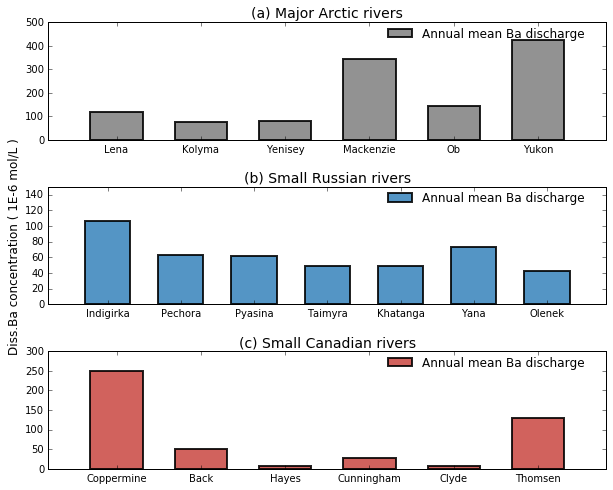

In [43]:
fig=plt.figure(figsize=(10, 8))
ax1=plt.subplot2grid((3, 1), (0, 0), colspan=3, rowspan=1)
ax2=plt.subplot2grid((3, 1), (1, 0), colspan=3, rowspan=1)
ax3=plt.subplot2grid((3, 1), (2, 0), colspan=3, rowspan=1)
plt.subplots_adjust(hspace = 0.4)

ax1.set_ylim(0, 500); ax1.set_xlim(0.5, 7.118)
ax1.bar(proxy_x, major_Ba, width=0.618, lw=2, color='gray', alpha=0.85, label='Annual mean Ba discharge') 
LG = ax1.legend(numpoints=1, bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax1.set_xticklabels(major_name); ax1.set_xticks(proxy_xmid)
ax1.set_title('(a) Major Arctic rivers', fontsize=14)

ax2.set_ylim(0, 150); ax2.set_xlim(0.5, 8.118)
ax2.bar(proxy_x2, Russia_small_Ba, width=0.618, lw=2, color=RB, alpha=0.85, label='Annual mean Ba discharge') 
LG = ax2.legend(numpoints=1, bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax2.set_xticklabels(Russia_name); ax2.set_xticks(proxy_xmid2)
ax2.set_ylabel('Diss.Ba concentration ( 1E-6 mol/L )', fontsize=12)
ax2.set_title('(b) Small Russian rivers', fontsize=14)

ax3.set_ylim(0, 300); ax3.set_xlim(0.5, 7.118)
ax3.bar(proxy_x, Canadian_small_Ba, width=0.618, lw=2, color=AM, alpha=0.85, label='Annual mean Ba discharge') 
LG = ax3.legend(numpoints=1, bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax3.set_xticklabels(Canadian_name);  ax3.set_xticks(proxy_xmid)
ax3.set_title('(c) Small Canadian rivers', fontsize=14)

fig.savefig('_publish/FIG3.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
            transparent=False, bbox_inches='tight', pad_inches=0.01)

In [44]:
from mpl_toolkits.mplot3d import Axes3D

In [45]:
names1 = ['Olenek', 'Taimyra', 'Khatanga', 'Pechora', 'Pyasina', 'Yana', 'Indigirka']
names2 = ['Clyde', 'Cunningham', 'Back', 'Thomsen', 'Coppermine']
names = ['Kolyma', 'Yenisey', 'Lena', 'Ob', 'Mackenzie', 'Yukon']

In [46]:
Mon = ['Jan', 'May', 'Sep', 'Dec']

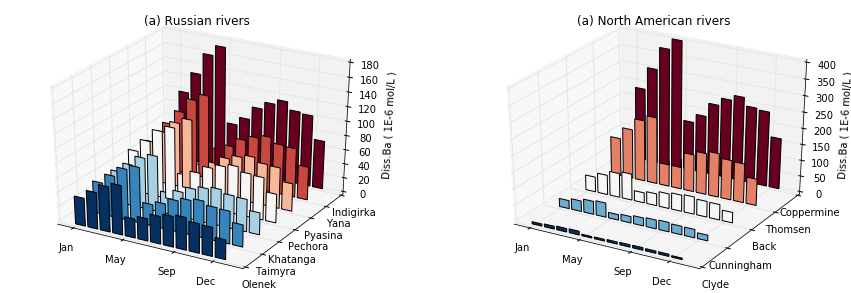

In [123]:
fig=plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


cs = plt.cm.RdBu_r(np.linspace(0, 1, 7))
ax1.bar(t, Olenek_Ba_nemo,    zs=0,  zdir='y', color=cs[0], label='Olenek')
ax1.bar(t, Taimyra_Ba_nemo,   zs=10, zdir='y', color=cs[1], label='Taimyra')
ax1.bar(t, Khatanga_Ba_nemo,  zs=20, zdir='y', color=cs[2], label='Khatanga')
ax1.bar(t, Pechora_Ba_nemo,   zs=30, zdir='y', color=cs[3], label='Pechora')
ax1.bar(t, Pyasina_Ba_nemo,   zs=40, zdir='y', color=cs[4], label='Pyasina')
ax1.bar(t, Yana_Ba_nemo,      zs=50, zdir='y', color=cs[5], label='Yana')
ax1.bar(t, Indigirka_Ba_nemo, zs=60, zdir='y', color=cs[6], label='Indigirka')
ax1.set_xticks([1, 5, 9, 12])
ax1.set_xticklabels(Mon)
ax1.set_yticklabels(names1)
ax1.set_zlabel('Diss.Ba ( 1E-6 mol/L )')
ax1.set_title('(a) Russian rivers')

cs2 = plt.cm.RdBu_r(np.linspace(0, 1, 5))
ax2.bar(t, Clyde_Ba_nemo,   zs=0,  zdir='y', color=cs2[0], label='Clyde')
ax2.bar(t, CH_Ba_nemo,      zs=15, zdir='y', color=cs2[1], label='Cunningham')
ax2.bar(t, Back_Ba_nemo,    zs=30, zdir='y', color=cs2[2], label='Back')
ax2.bar(t, Thomsen_Ba_nemo, zs=45, zdir='y', color=cs2[3], label='Thomsen')
ax2.bar(t, CPM_Ba_nemo,     zs=60, zdir='y', color=cs2[4], label='Coppermine')
ax2.set_xticks([1, 5, 9, 12])
ax2.set_xticklabels(Mon)
ax2.set_yticks([0, 15, 30, 45, 60])
ax2.set_yticklabels(names2)
ax2.set_zlabel('Diss.Ba ( 1E-6 mol/L )')
ax2.set_title('(a) North American rivers')

#fig.savefig('small_rivers.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0.01)

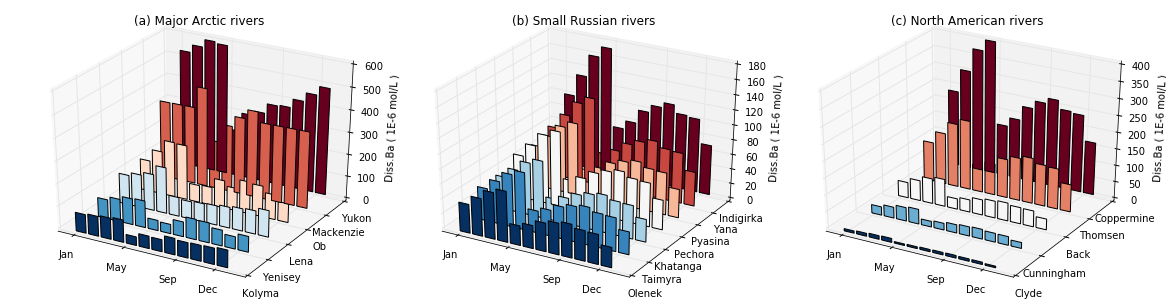

In [47]:
fig=plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

cs = plt.cm.RdBu_r(np.linspace(0, 1, 6))
ax1.bar(t, Kolyma_Ba_nemo,    zs=0,  zdir='y', color=cs[0], label='Kolyma')
ax1.bar(t, Yenisey_Ba_nemo,   zs=10, zdir='y', color=cs[1], label='Yenisey')
ax1.bar(t, Lena_Ba_nemo,      zs=20, zdir='y', color=cs[2], label='Lena')
ax1.bar(t, Ob_Ba_nemo,        zs=30, zdir='y', color=cs[3], label='Ob')
ax1.bar(t, Mackenzie_Ba_nemo, zs=40, zdir='y', color=cs[4], label='Mackenzie')
ax1.bar(t, Yukon_Ba_nemo,     zs=50, zdir='y', color=cs[5], label='Yukon')
ax1.set_xticks([1, 5, 9, 12])
ax1.set_xticklabels(Mon)
ax1.set_yticklabels(names)
ax1.set_zlabel('Diss.Ba ( 1E-6 mol/L )')
ax1.set_title('(a) Major Arctic rivers')

cs = plt.cm.RdBu_r(np.linspace(0, 1, 7))
ax2.bar(t, Olenek_Ba_nemo,    zs=0,  zdir='y', color=cs[0], label='Olenek')
ax2.bar(t, Taimyra_Ba_nemo,   zs=10, zdir='y', color=cs[1], label='Taimyra')
ax2.bar(t, Khatanga_Ba_nemo,  zs=20, zdir='y', color=cs[2], label='Khatanga')
ax2.bar(t, Pechora_Ba_nemo,   zs=30, zdir='y', color=cs[3], label='Pechora')
ax2.bar(t, Pyasina_Ba_nemo,   zs=40, zdir='y', color=cs[4], label='Pyasina')
ax2.bar(t, Yana_Ba_nemo,      zs=50, zdir='y', color=cs[5], label='Yana')
ax2.bar(t, Indigirka_Ba_nemo, zs=60, zdir='y', color=cs[6], label='Indigirka')
ax2.set_xticks([1, 5, 9, 12])
ax2.set_xticklabels(Mon)
ax2.set_yticklabels(names1)
ax2.set_zlabel('Diss.Ba ( 1E-6 mol/L )')
ax2.set_title('(b) Small Russian rivers')

cs2 = plt.cm.RdBu_r(np.linspace(0, 1, 5))
ax3.bar(t, Clyde_Ba_nemo,   zs=0,  zdir='y', color=cs2[0], label='Clyde')
ax3.bar(t, CH_Ba_nemo,      zs=15, zdir='y', color=cs2[1], label='Cunningham')
ax3.bar(t, Back_Ba_nemo,    zs=30, zdir='y', color=cs2[2], label='Back')
ax3.bar(t, Thomsen_Ba_nemo, zs=45, zdir='y', color=cs2[3], label='Thomsen')
ax3.bar(t, CPM_Ba_nemo,     zs=60, zdir='y', color=cs2[4], label='Coppermine')
ax3.set_xticks([1, 5, 9, 12])
ax3.set_xticklabels(Mon)
ax3.set_yticks([0, 15, 30, 45, 60])
ax3.set_yticklabels(names2)
ax3.set_zlabel('Diss.Ba ( 1E-6 mol/L )')
ax3.set_title('(c) North American rivers')

#fig.savefig('AN_FIG1.pdf', dpi=600, orientation='landscape', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0.01)
fig.savefig('_publish/FIG4.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
                bbox_inches='tight', pad_inches=0.1)

# Save results

In [125]:
save_var = { 'Lena'     : np.squeeze(Lena_Ba_nemo),\
             'Kolyma'   : np.squeeze(Kolyma_Ba_nemo),\
             'Yenisey'  : np.squeeze(Yenisey_Ba_nemo),\
             'Mackenzie': np.squeeze(Mackenzie_Ba_nemo),\
             'Ob'       : np.squeeze(Ob_Ba_nemo),\
             'Yukon'    : np.squeeze(Yukon_Ba_nemo), \
             'Indigirka': np.squeeze(Indigirka_Ba_nemo), \
             'Khatanga' : np.squeeze(Khatanga_Ba_nemo), \
             'Pechora'  : np.squeeze(Pechora_Ba_nemo), \
             'Pyasina'  : np.squeeze(Pyasina_Ba_nemo), \
             'Taimyra'  : np.squeeze(Taimyra_Ba_nemo), \
             'Yana'     : np.squeeze(Yana_Ba_nemo), \
             'Olenek'   : np.squeeze(Olenek_Ba_nemo), \
             'CPM'      : np.squeeze(CPM_Ba_nemo), \
             'Back'     : np.squeeze(Back_Ba_nemo), \
             'Hayes'    : np.squeeze(Hayes_Ba_nemo), \
             'CH'       : np.squeeze(CH_Ba_nemo), \
             'Clyde'    : np.squeeze(Clyde_Ba_nemo), \
             'Thomsen'  : np.squeeze(Thomsen_Ba_nemo)
            }
scipy.io.savemat('_data/Exchange/River_Ba_nemo.mat', mdict=save_var)